In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import requests
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

from astropy.stats import LombScargle

from kepler_op import KeplerOp
kepler = KeplerOp()

In [3]:
def lomb_scargle_estimator(x, y, yerr=None,
                           min_period=None, max_period=None,
                           filter_period=None,
                           max_peaks=2,
                           **kwargs):
    """
    Estimate period of a time series using the periodogram
    Args:
        x (ndarray[N]): The times of the observations
        y (ndarray[N]): The observations at times ``x``
        yerr (Optional[ndarray[N]]): The uncertainties on ``y``
        min_period (Optional[float]): The minimum period to consider
        max_period (Optional[float]): The maximum period to consider
        filter_period (Optional[float]): If given, use a high-pass filter to
            down-weight period longer than this
        max_peaks (Optional[int]): The maximum number of peaks to return
            (default: 2)
    Returns:
        A dictionary with the computed ``periodogram`` and the parameters for
        up to ``max_peaks`` peaks in the periodogram.
    """
    if min_period is not None:
        kwargs["maximum_frequency"] = 1.0 / min_period
    if max_period is not None:
        kwargs["minimum_frequency"] = 1.0 / max_period

    # Estimate the power spectrum
    model = LombScargle(x, y, yerr)
    freq, power = model.autopower(method="fast", normalization="psd", **kwargs)
    power /= len(x)
    power_est = np.array(power)

    # Filter long periods
    if filter_period is not None:
        freq0 = 1.0 / filter_period
        filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
        power *= filt

    # Find and fit peaks
    peak_inds = (power[1:-1] > power[:-2]) & (power[1:-1] > power[2:])
    peak_inds = np.arange(1, len(power)-1)[peak_inds]
    peak_inds = peak_inds[np.argsort(power[peak_inds])][::-1]
    peaks = []
    for i in peak_inds[:max_peaks]:
        A = np.vander(freq[i-1:i+2], 3)
        w = np.linalg.solve(A, np.log(power[i-1:i+2]))
        sigma2 = -0.5 / w[0]
        freq0 = w[1] * sigma2
        peaks.append(dict(
            log_power=w[2] + 0.5*freq0**2 / sigma2,
            period=1.0 / freq0,
            period_uncert=np.sqrt(sigma2 / freq0**4),
        ))

    return dict(
        periodogram=(freq, power_est),
        peaks=peaks,
    )

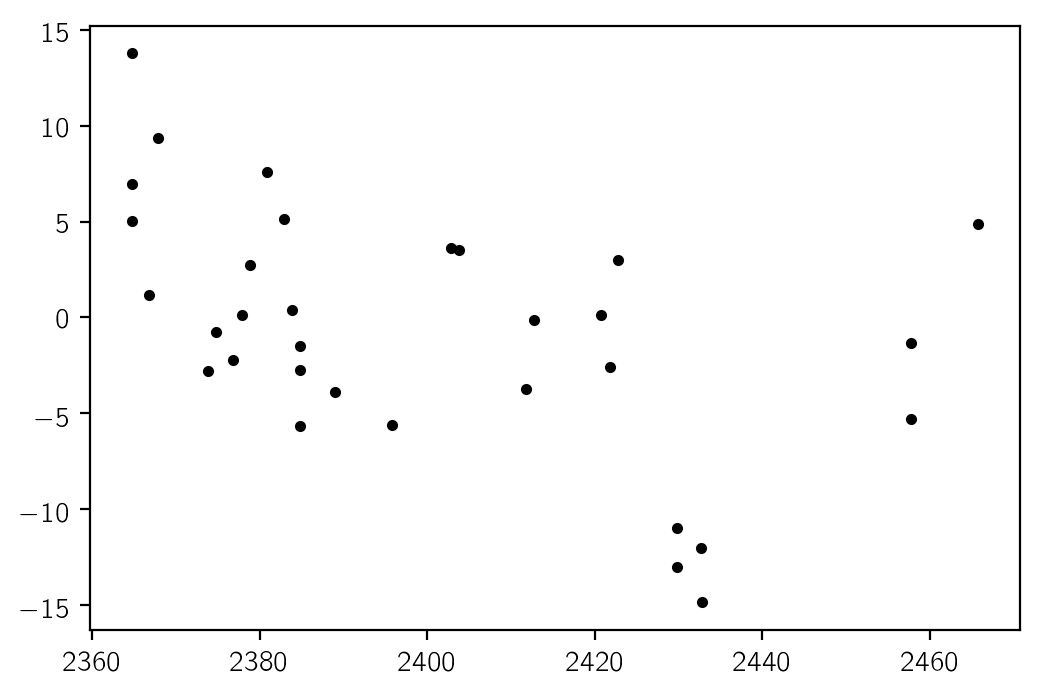

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv", index_col=0)
t = np.array(df.t, dtype=float)
y = np.array(df.vel, dtype=float)
yerr = np.array(df.errvel, dtype=float)
plt.plot(t, y, ".k");

In [5]:
# def get_dataset(args):
#     ind, url = args
#     r = requests.get(url)
#     if r.status_code != requests.codes.ok:
#         r.raise_for_status()
#     return np.array([l.split() + [ind] for l in r.text.splitlines()
#                      if not l.startswith("\\") and not l.startswith("|")],
#                     dtype=float)

# urls = [
#     "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_002.tbl",
# #     "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_003.tbl",
# #     "https://exoplanetarchive.ipac.caltech.edu/data/ExoData/0074/0074995/data/UID_0074995_RVC_001.tbl",
# ]
# data = np.concatenate(list(map(get_dataset, enumerate(urls))), axis=0)
# inds = np.argsort(data[:, 0])
# data = np.array(data[inds])

# t = np.array(data[:, 0])
# y = np.array(data[:, 1])
# yerr = np.array(data[:, 2])

# plt.plot(data[:, 0], data[:, 1], ".k");

In [6]:
ref_time = np.mean(t)
ref_vel = np.median(y)

t -= ref_time
# y -= ref_vel

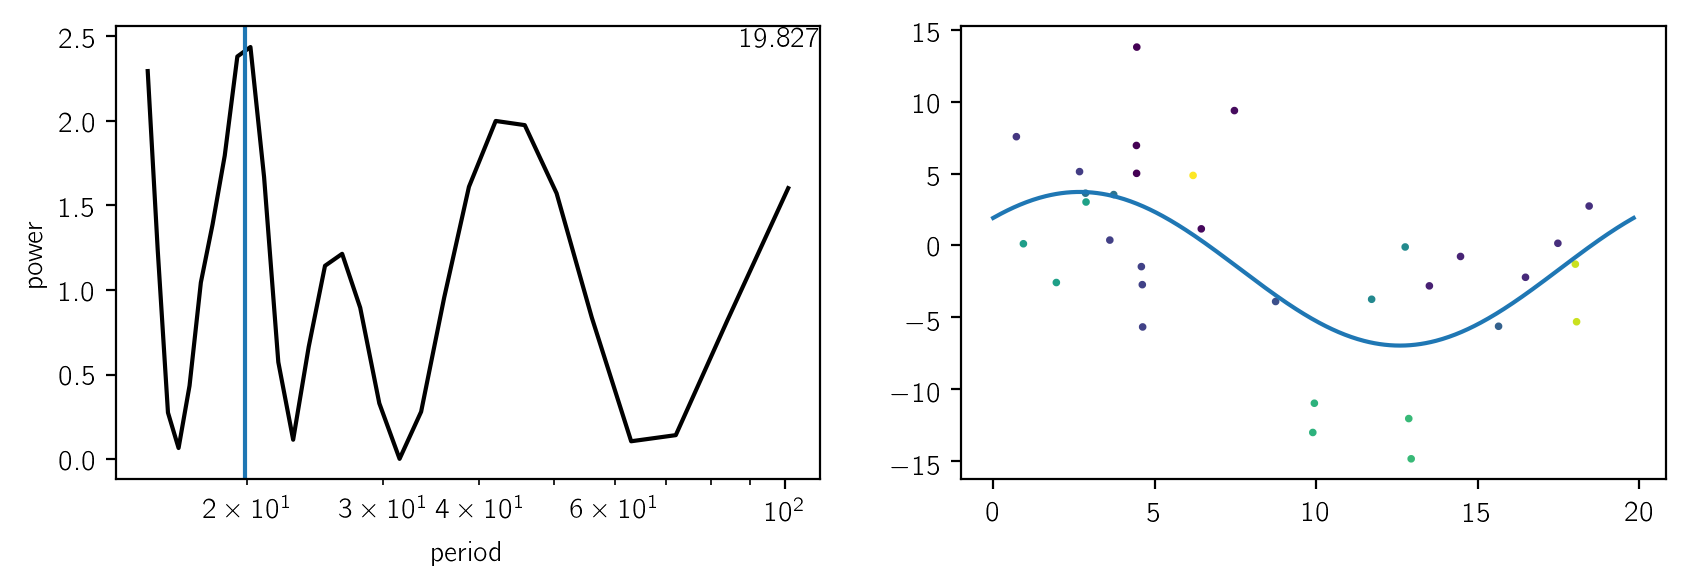

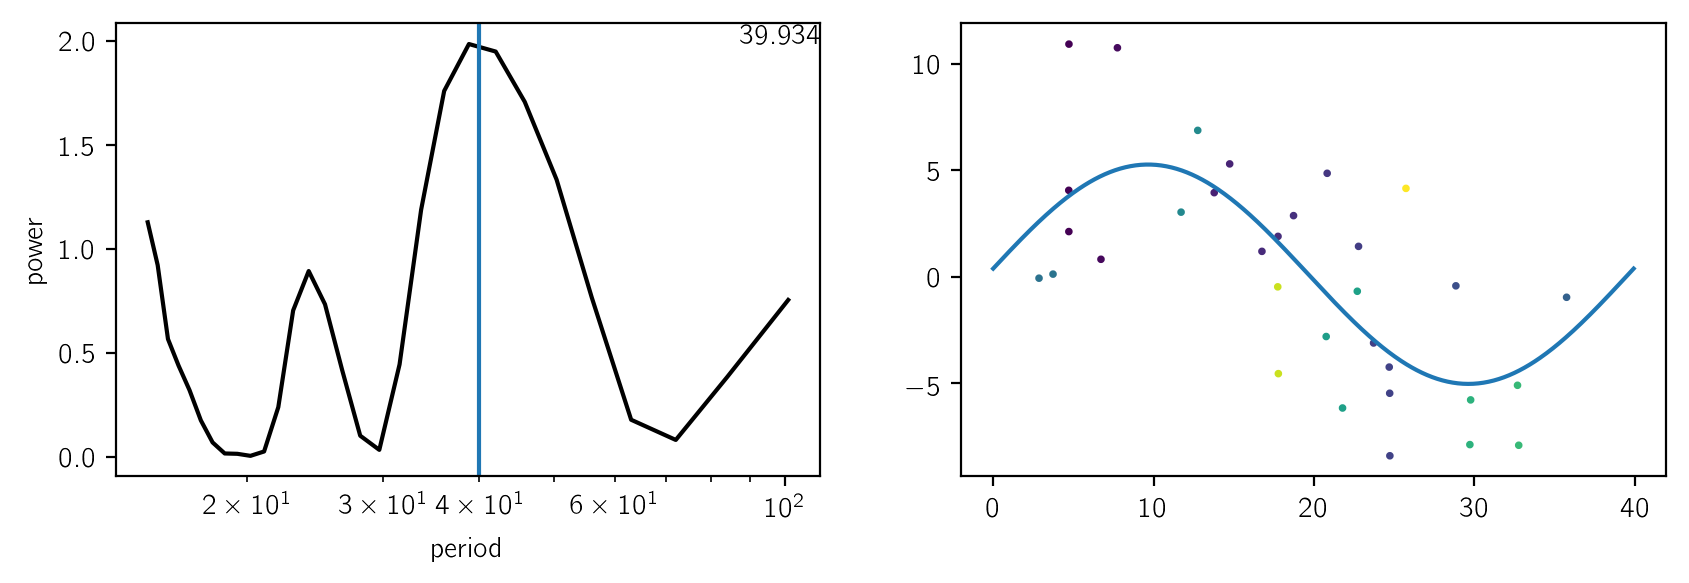

In [15]:
# min_period = np.median(np.diff(np.sort(t)))
min_period = 15.0
max_period = (t.max() - t.min())
min_amp = 0.5*np.min(yerr)
max_amp = y.max() - y.min()

y0 = np.array(y)
peaks = []
for i in range(2):
    m = lomb_scargle_estimator(t, y0, yerr, max_period=max_period, min_period=min_period, max_peaks=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.semilogx(1.0/m["periodogram"][0], m["periodogram"][1], "k")

    for peak in m["peaks"]:
        ax1.axvline(peak["period"])
    ax1.set_xlabel("period")
    ax1.set_ylabel("power")

    peak = dict(m["peaks"][0])
    A = np.vstack([
        np.sin(2*np.pi*t/peak["period"]),
        np.cos(2*np.pi*t/peak["period"]),
        np.ones_like(t),
    ]).T
    w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, y0))
    x = np.linspace(0, peak["period"], 500)
    Am = np.vstack([
        np.sin(2*np.pi*x/peak["period"]),
        np.cos(2*np.pi*x/peak["period"]),
        np.ones_like(x),
    ]).T
    model = np.dot(Am, w)
    peak["amp"] = 0.5*(model.max() - model.min())
    peak["phase"] = np.arctan2(w[1], w[0])

    ax2.scatter(t % peak["period"], y0, c=t, s=3)
    ax2.plot(x, model)

    ax1.annotate("{0:.3f}".format(peak["period"]), xy=(1, 1),
                 xycoords="axes fraction", ha="right", va="top")
    
    y0 -= np.dot(A, w)
    
    peaks.append(peak)

In [16]:
n_planets = len(peaks)
test_t = np.linspace(t.min(), t.max(), 5000)

def unit_vector(name):
    vec = pm.Normal(name + "_vec", shape=(2, n_planets),
                    testval=np.random.randn(2, n_planets))
    vec = vec / tt.sqrt(tt.sum(vec**2, axis=0))[None, :]
    cos_ = vec[0]
    sin_ = vec[1]
    value = tt.arctan2(sin_, cos_)
    pm.Deterministic(name, var=value)
    return cos_, sin_, value, vec

with pm.Model() as model:
    
    logK = pm.Uniform("logK", lower=np.log(min_amp), upper=np.log(max_amp), shape=(n_planets,),
                      testval=np.log([np.clip(p["amp"], min_amp+1e-2, max_amp-1e-2) for p in peaks[:n_planets]]))
    logP = pm.Uniform("logP", lower=np.log(min_period), upper=np.log(max_period), shape=(n_planets,),
                      testval=np.log([p["period"] for p in peaks[:n_planets]]))
    
    eccen = pm.Beta("eccen", alpha=0.867, beta=3.03, shape=(n_planets,),
                    testval=0.1 + np.zeros(n_planets))
    cos_omega, sin_omega, omega, omega_vec = unit_vector("omega")
    cos_phi, sin_phi, phi, phi_vec = unit_vector("phi")
    
    v0 = pm.Normal("v0", mu=np.mean(y), sd=100.0, testval=np.mean(y))
    dvdt = pm.Normal("dvdt", mu=0.0, sd=100.0, testval=0.0)
    d2vdt2 = pm.Normal("d2vdt2", mu=0.0, sd=100.0, testval=0.0)
    logs2 = pm.Uniform("logs2", lower=-5.0, upper=5.0, testval=0.0)
    
    n = 2*np.pi*tt.exp(-logP)
    K = tt.exp(logK)
    s2 = tt.exp(logs2)
    pm.Deterministic("t0", var=(phi + omega) / n)

    def get_rv_models(t_):
        mean_anom = n * t_[:, None] - (phi + omega)
        eccen_arg = eccen + tt.zeros_like(mean_anom)
        eccen_anom = kepler(mean_anom, eccen_arg)
        f = 2*tt.arctan2(tt.sqrt(1+eccen)*tt.tan(0.5*eccen_anom),
                         tt.sqrt(1-eccen)+tt.zeros_like(eccen_anom))
        return K * (cos_omega*(tt.cos(f)+eccen) - sin_omega*tt.sin(f))
    
    rv_models = get_rv_models(t)
    pm.Deterministic("rv_models", var=rv_models)

    # Sum the contributions from each planet
    bkg_model = v0 + dvdt * t + d2vdt2 * t**2
    rv_model = bkg_model + tt.sum(rv_models, axis=1)
    pm.Deterministic("rv_model", var=rv_model)
    
    sd = tt.sqrt(yerr**2 + s2)
    pm.Normal("obs", mu=rv_model, sd=sd, observed=y)
    
    test_rv_models = get_rv_models(test_t)
    pm.Deterministic("test_rv_models", var=test_rv_models)
    test_bkg_model = v0 + dvdt * test_t + d2vdt2 * test_t**2
    test_rv_model = test_bkg_model + tt.sum(test_rv_models, axis=1)
    pm.Deterministic("test_rv_model", var=test_rv_model)
    
    pm.Potential("order", tt.switch(tt.all(logP[:-1] < logP[1:]), 0.0, -np.inf))
    
    pm.Deterministic("logp", var=model.logpt)

    params_no_period = [v for v in model.vars if v.name != "logP_interval__"]
    
    res = pm.find_MAP(vars=[phi_vec])
    res = pm.find_MAP(res, vars=[omega_vec])
    res = pm.find_MAP(res, vars=params_no_period)
    res = pm.find_MAP(res, vars=logP)
    res = pm.find_MAP(res, vars=params_no_period)
    res = pm.find_MAP(res, vars=logP)
    res = pm.find_MAP(res)

    trace = pm.sample(start=res, draws=4000, tune=4000)

logp = -130.67, ||grad|| = 2.6281: 100%|██████████| 132/132 [00:00<00:00, 2428.17it/s]
logp = -128.41, ||grad|| = 46.254: 100%|██████████| 103/103 [00:00<00:00, 2558.43it/s]
logp = -127.91, ||grad|| = 1,274.2: 100%|██████████| 223/223 [00:00<00:00, 1853.44it/s]    
logp = -126.65, ||grad|| = 73.195: 100%|██████████| 10/10 [00:00<00:00, 2434.87it/s]
logp = -121.53, ||grad|| = 6.8307e+06: 100%|██████████| 27/27 [00:00<00:00, 717.37it/s]
logp = -121.31, ||grad|| = 14.648: 100%|██████████| 8/8 [00:00<00:00, 1727.47it/s]
logp = -120.94, ||grad|| = 153.3: 100%|██████████| 42/42 [00:00<00:00, 1714.69it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs2, d2vdt2, dvdt, v0, phi_vec, omega_vec, eccen, logP, logK]
INFO:pymc3:NUTS: [logs2, d2vdt2, dvdt, v0, phi_vec, 

In [17]:
pm.summary(trace, varnames=["logK", "logP", "eccen", "omega", "phi", "v0", "dvdt", "d2vdt2", "logs2", "logp"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logK__0,1.457462,0.435626,0.025347,0.605775,2.449289,99.143921,1.013441
logK__1,1.573724,0.485438,0.020573,0.654594,2.611956,386.889707,1.002453
logP__0,3.072661,0.188458,0.016552,2.799857,3.548015,32.263810,1.054558
logP__1,4.035462,0.326536,0.023934,3.108819,4.526578,49.502673,1.006840
eccen__0,0.288301,0.171846,0.004854,0.000027,0.574627,1064.862186,1.000090
eccen__1,0.190633,0.155079,0.003759,0.000010,0.492324,1790.754701,1.001004
omega__0,-0.050618,1.124742,0.019066,-2.840596,2.290067,3690.757637,1.000907
omega__1,0.262655,1.598571,0.051324,-2.599806,3.118197,281.938625,1.007204
phi__0,0.607620,0.646786,0.029277,-0.334642,1.694366,253.940501,1.005673
phi__1,0.853302,0.858449,0.072114,-2.081229,1.810655,34.394503,1.004061


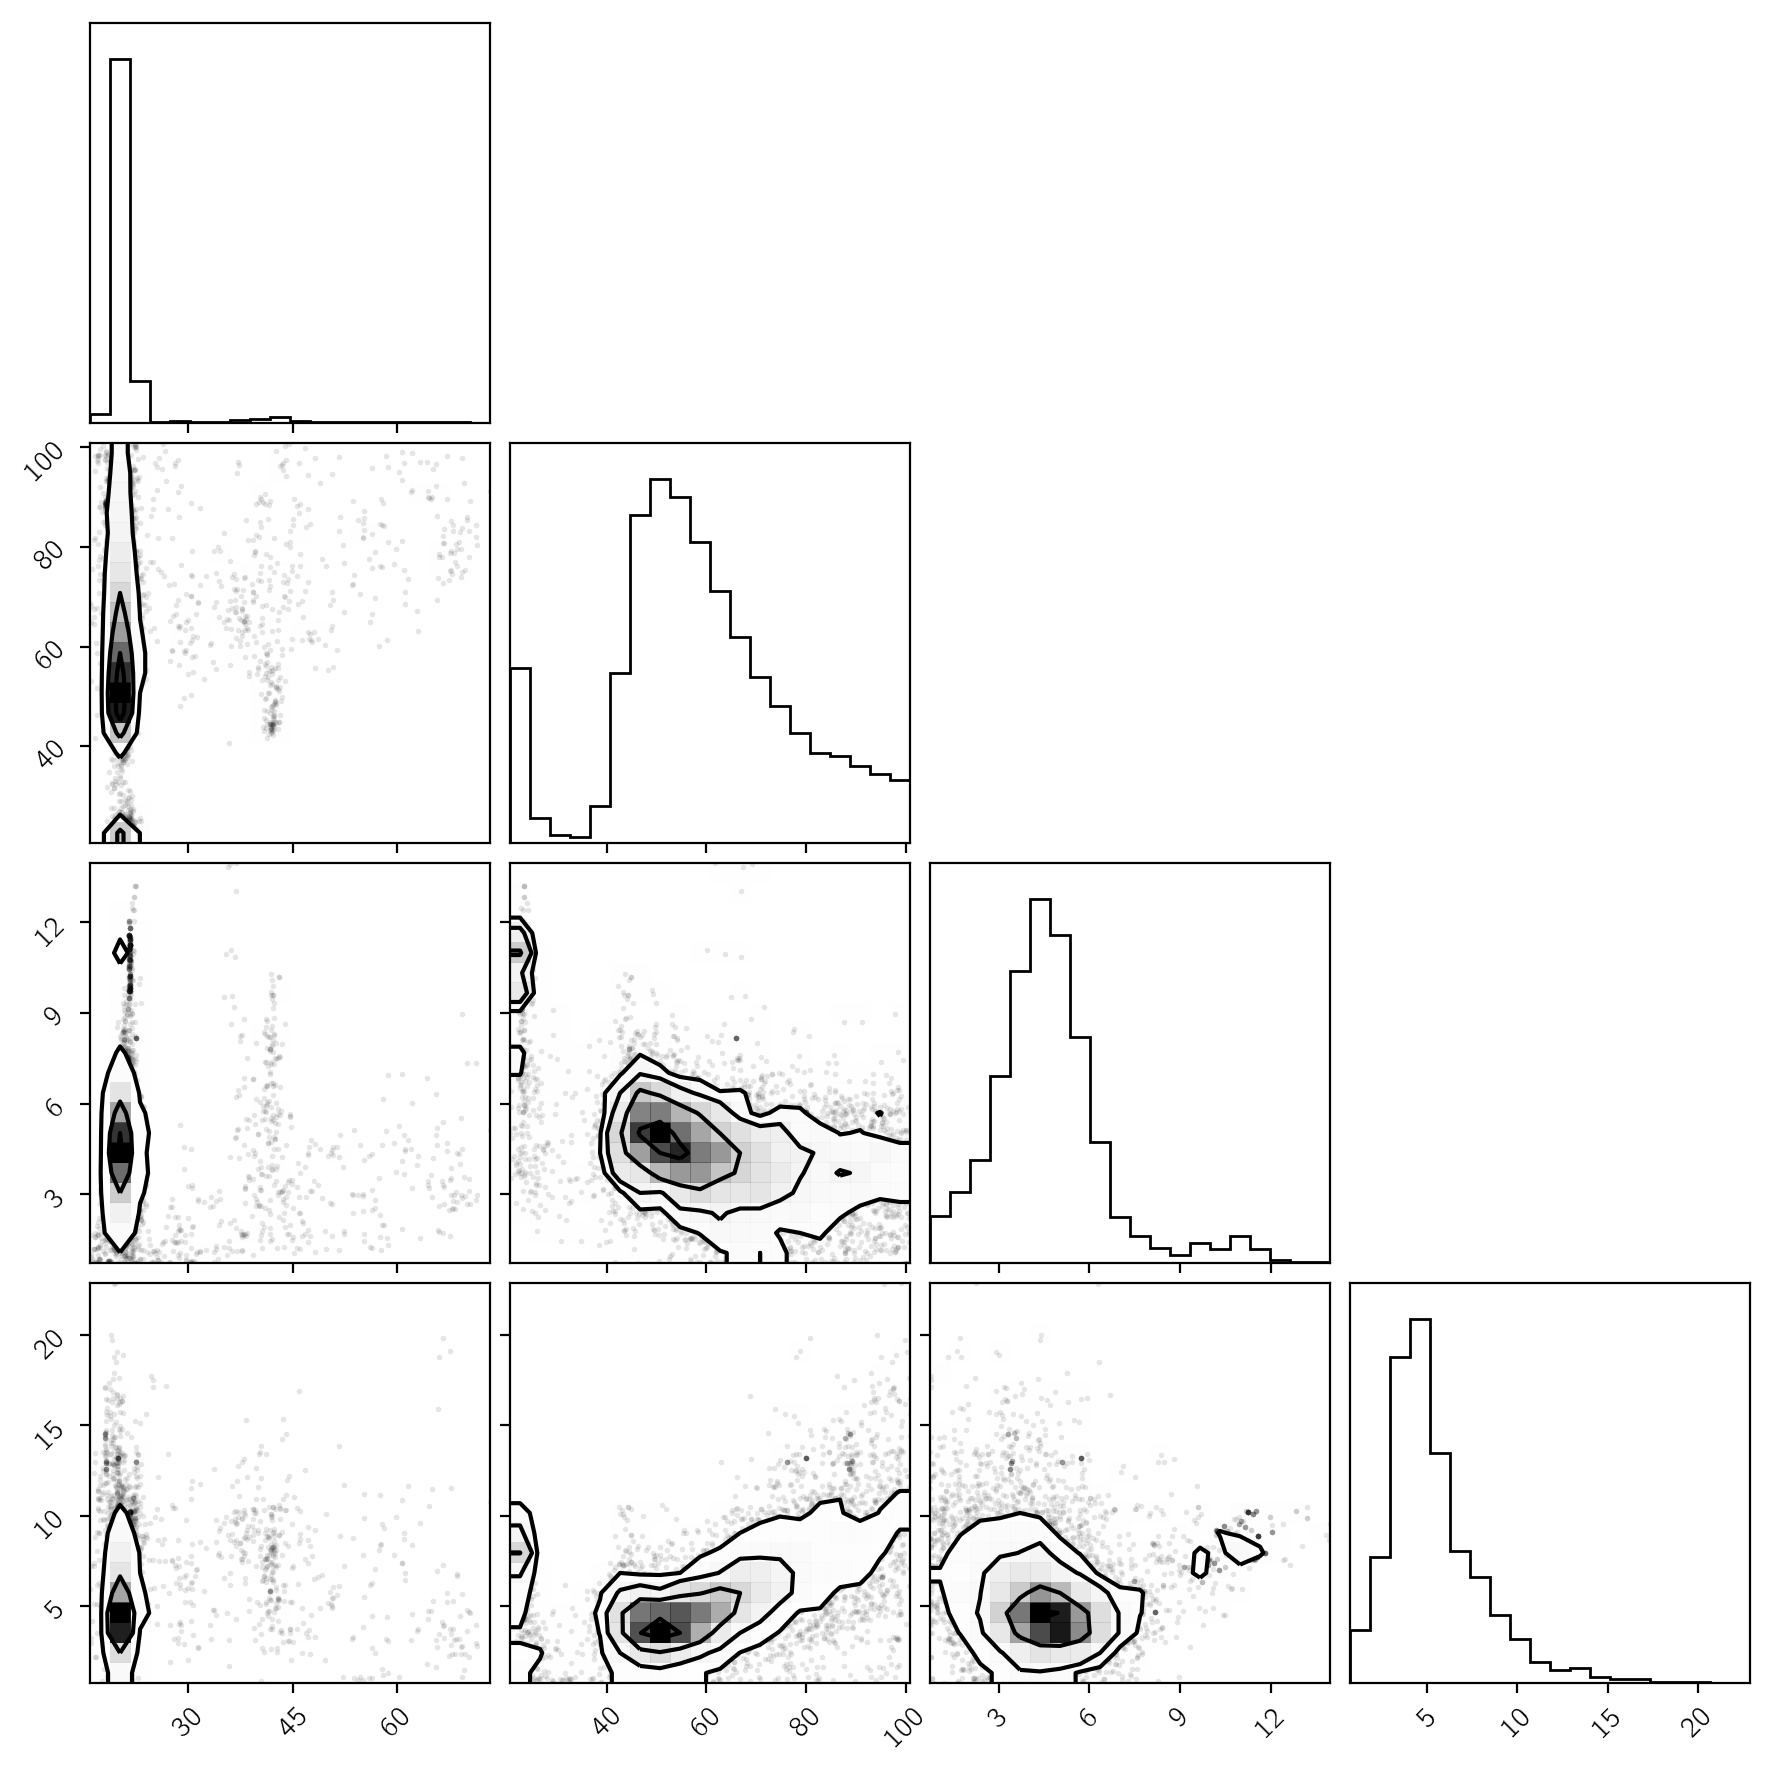

In [18]:
import corner

samples = np.concatenate([np.exp(trace[k]) for k in ["logP", "logK"]], axis=1)
corner.corner(samples);

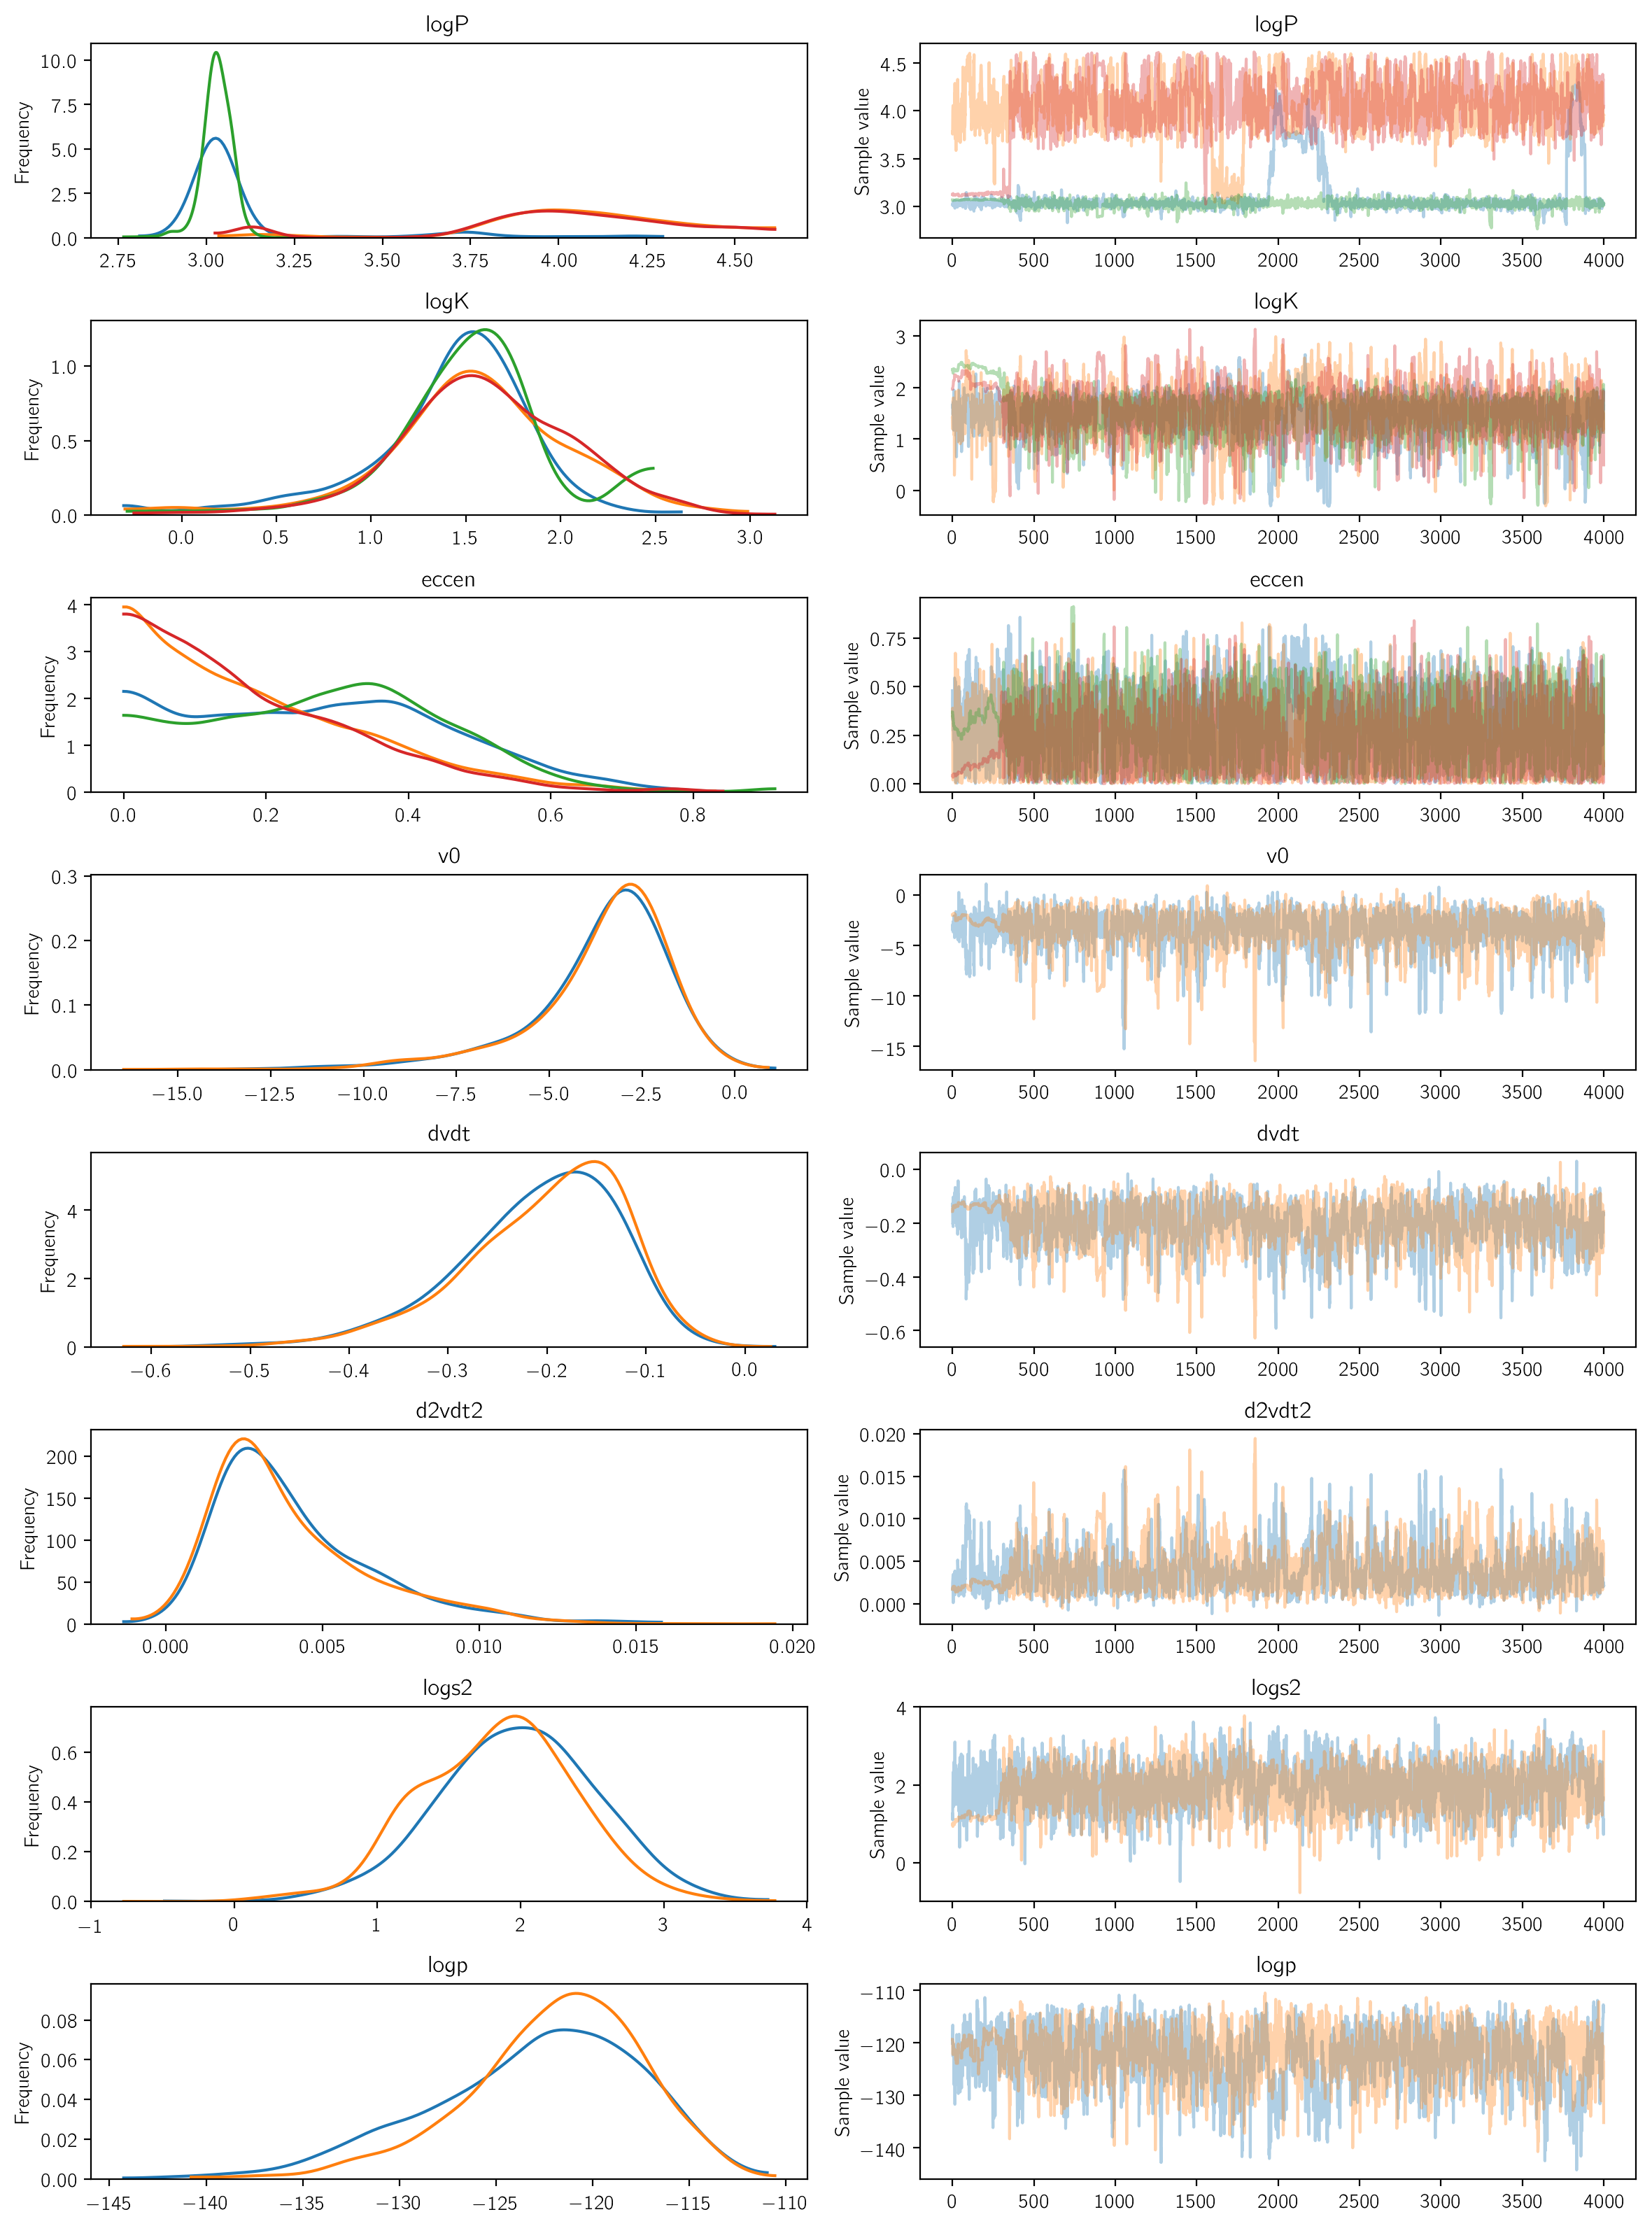

In [19]:
pm.traceplot(trace, varnames=["logP", "logK", "eccen", "v0", "dvdt", "d2vdt2", "logs2", "logp"]);

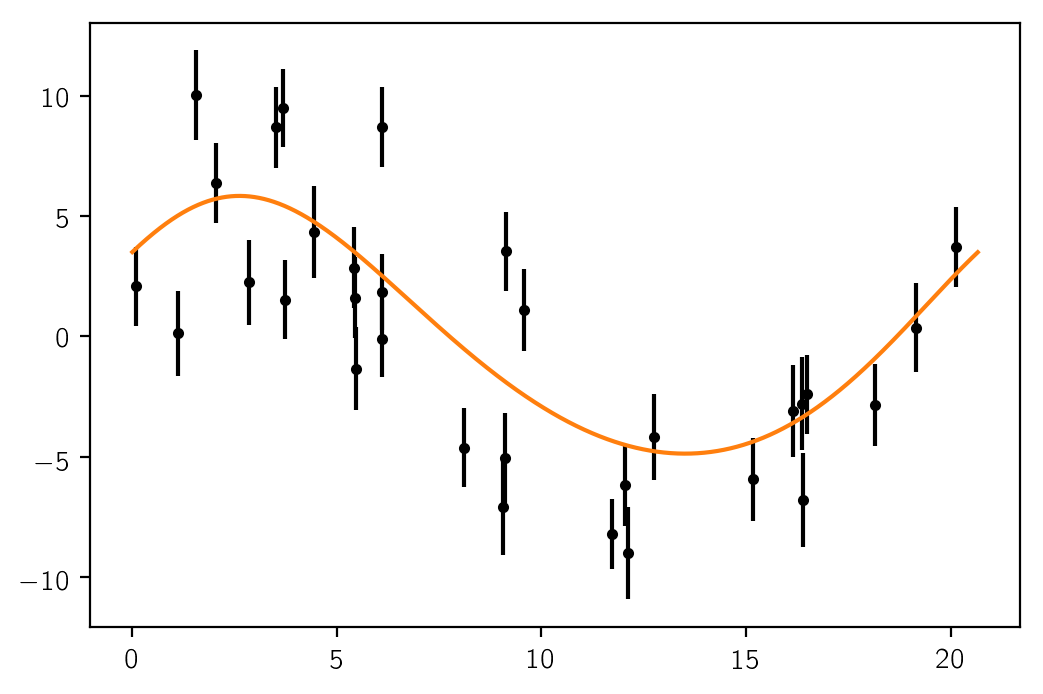

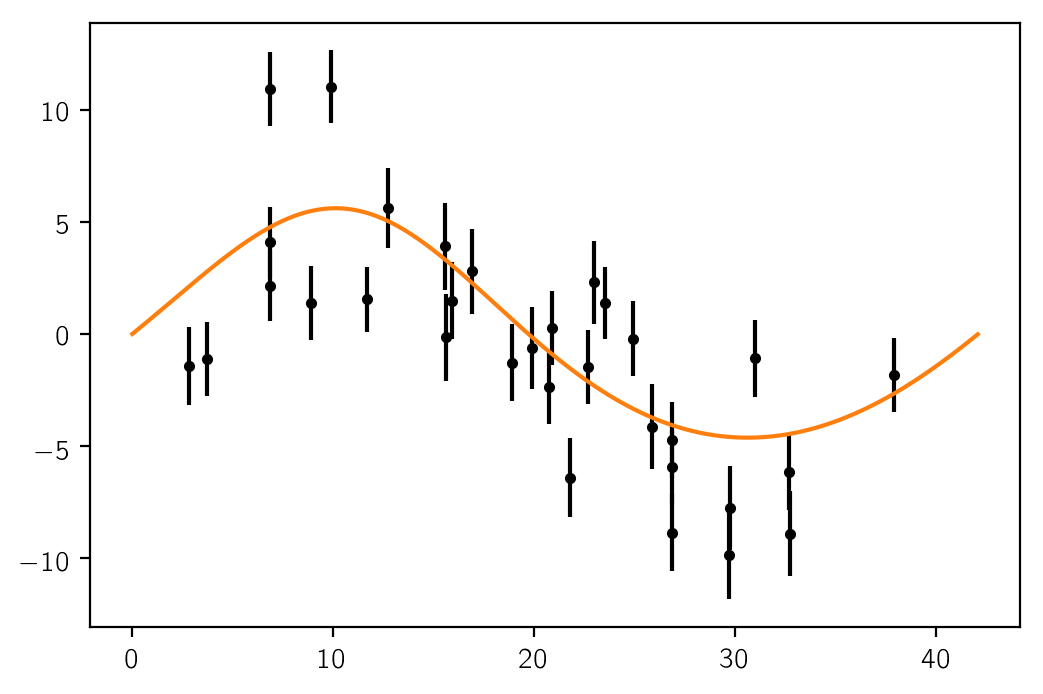

In [20]:
mods = res["rv_models"]
resid = y - res["rv_model"]

for i in range(n_planets):
    plt.figure()
    period = np.exp(res["logP"][i])
    plt.errorbar(t % period, resid + mods[:, i], yerr=yerr, fmt=".k")
    x = test_t % period
    inds = np.argsort(x)
    plt.plot(x[inds], res["test_rv_models"][:, i][inds], color="C1")

In [21]:
trace["logp"]

array([-120.14616417, -117.90176122, -116.66558103, ..., -126.40348423,
       -123.64595579, -135.24023784])

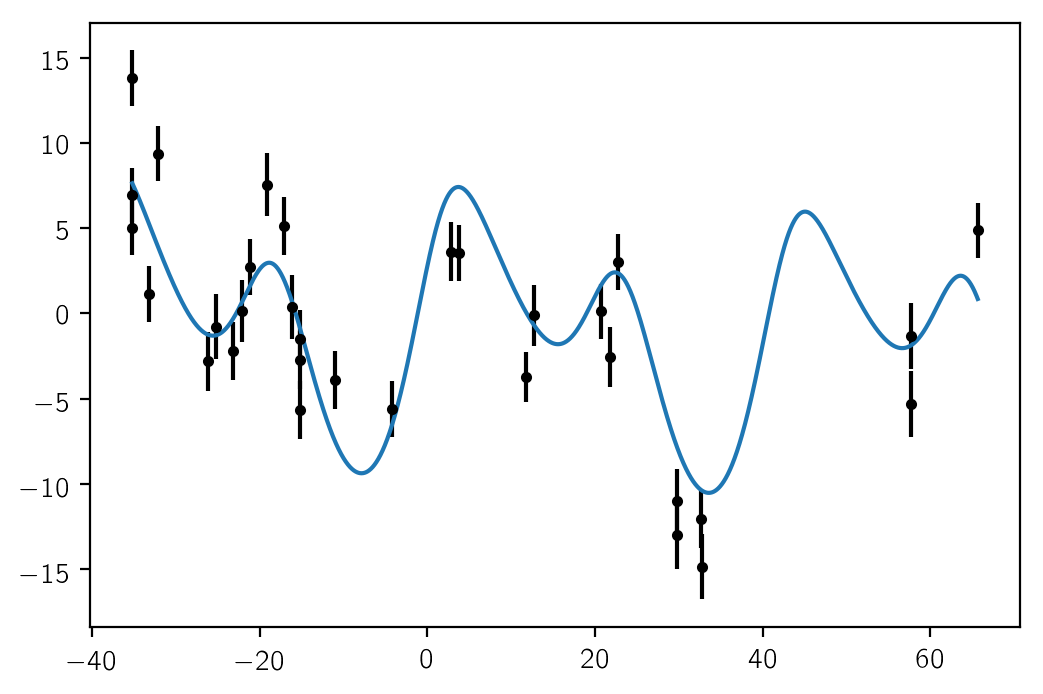

In [22]:
plt.errorbar(t, y, yerr=yerr, fmt=".k")
plt.plot(test_t, res["test_rv_model"])